In [1]:
import numpy as np
from scipy.interpolate import griddata
import scipy.io
from scipy import signal
from data_preprocessing import *
from data_loader import load_data
import warnings
from metrics import *
import os
import glob
import h5py
import numpy as np
import mne
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2,l1
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from multi_objective_cnn import *

In [9]:
dataset = '8_channel_cVEP'
with open('./datasets/{}.pickle'.format(dataset), 'rb') as handle:
    data = pickle.load(handle)

    X = data['X']
    Ys = data['Ys']
    Yt = data['Yt']

In [3]:
def run_dynamic_stopping(dataset,mode,model):
    with open('./datasets/{}.pickle'.format(dataset), 'rb') as handle:
        data = pickle.load(handle)

        X = data['X']
        Ys = data['Ys']
        Yt = data['Yt']

    # Preprocessing data
    low_cutoff = 2
    high_cutoff = 30
    sfreq = 240
    X = bandpass_filter_data(X, low_cutoff, high_cutoff, sfreq)

    if(dataset=='8_channel_cVEP'):
        dataset_txt = '8-channel dataset'
        n_subjects = 30
        n_classes = 21
        n_channels = 8
        mat = scipy.io.loadmat('./datasets/8_channel_cVEP/resources/mgold_61_6521_flip_balanced_20.mat')
        codes = mat['codes'].astype('float32')
        codebook = np.moveaxis(codes,1,0).astype('float32')

    if(dataset=='256_channel_cVEP'):
        dataset_txt = '256-channel dataset'
        n_subjects = 5
        n_classes = 36
        n_channels = 256
        codebook = np.load('./datasets/256_channel_cVEP/Scripts/codebook_36t.npy')[:n_classes]
        codes = np.moveaxis(codebook,1,0)

        X, rejected_chans = remove_bad_channels(X)
        X, Ys, Yt = augment_data_chan(X, Ys, Yt)

    results = {}
    for i in range(0,n_subjects):
        #print("Train on subject {}".format(i+1))
        results[i+1] = {}
        X_new = X[i]
        ys_new = Ys[i]
        yt_new = Yt[i]
        
        if dataset =='8_channel_cVEP':
            yt_new = yt_new[..., np.newaxis]
            
        y_new= np.concatenate((yt_new,ys_new), axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2,stratify=y_new[:,0], shuffle= True)

        if(dataset=='256_channel_cVEP'):
            X_train1 = X_train[:,:,:256]
            X_train2 = X_train[:,:,256:512]

            X_test1 = X_test_fold[:,:,:256]
            X_test2 = X_test_fold[:,:,256:512]

            X_train = np.concatenate((X_train1,X_train2), axis=0)
            X_test = np.concatenate((X_test1,X_test2), axis=0)

            yt_train1 = y_train[:,0]
            yt_train2 = y_train[:,1]
            ys_train1 = y_train[:,2:128]
            ys_train2 = y_train[:,128:254]

            yt_test1 = y_test[:,0]
            yt_test2 = y_test[:,1]
            ys_test1 = y_test[:,2:128]
            ys_test2 = y_test[:,128:254]


            ys_train = np.concatenate((ys_train1,ys_train2), axis=0)
            yt_train = np.concatenate((yt_train1,yt_train2), axis=0)

            ys_test = np.concatenate((ys_test1,ys_test2), axis=0)
            yt_test = np.concatenate((yt_test1,yt_test2), axis=0)

        X_train = standardize_data(X_train)
        X_test = standardize_data(X_test)

        yt_train = to_categorical(yt_train)
        yt_test = to_categorical(yt_test)

        multi_objective_cnn_model = build_multi_objective_cnn_model(n_channels,n_classes)
        checkpoint_filepath = './saved_models/{}/{}/{}/S{}/'.format(model,dataset,mode,i+1)
        multi_objective_cnn_model.load_weights(checkpoint_filepath).expect_partial()

#         loss, _,_, seq_accuracy, category_accuracy = multi_objective_cnn_model.evaluate(x = X_test, y = {"sequence": ys_test, 
#                                                                                         "category": yt_test}, verbose=0)
        acc_time_step =[]
        itr_time_step = []
        conf_diff_time_step = []
        conf_max_time_step = []
        
        pred_time_step = np.zeros((X_test.shape[0],X_test.shape[1],n_classes))
        for k in range(0, X_test.shape[1]):
            X_test_new = X_test.copy()
            X_test_new[:,k:,:] = 0

            _, pred = multi_objective_cnn_model.predict(X_test_new)
            prediction = np.argmax(pred,axis=1)
            
            pred_time_step[:,k] = pred
            
            conf_diff = np.array([])
            conf_max = np.array([])
            for n in range(0,X_test.shape[0]):
                conf_scores = pred_time_step[n,k,:]
                conf_scores = np.sort(conf_scores)[::-1]
                conf_scores_diff = conf_scores[0]-conf_scores[1]
                conf_diff = np.append(conf_diff, conf_scores_diff)
                conf_max = np.append(conf_max, conf_scores[0])
            
            conf_diff_time_step.append(np.mean(conf_diff))
            conf_max_time_step.append(np.mean(conf_max))
            
            acc = (np.sum(prediction == np.argmax(yt_test,axis=1))/len(prediction))
            acc_time_step.append(acc)
            
            accuracy = acc
            num_trials = X_test_new.shape[0]
            time_min = (X_test_new.shape[0]* k*(2.1/504)*(1/60))
            itr = calculate_ITR(n_classes, accuracy, time_min, num_trials)
            itr_time_step.append(itr)
            
            result_val = [acc,itr,conf_max,conf_diff]
            
            
        results[i+1]['conf_max_time_steps'] = np.array(conf_max)
        results[i+1]['conf_diff_time_steps'] = np.array(conf_max)
        
        results[i+1]['variable_time_steps'] = np.array(acc_time_step)
        results[i+1]['ITR_time_steps'] = np.array(itr_time_step)
        results[i+1]['pred_time_step'] = pred_time_step
        
        results[i+1]['pred_time_step']
        
#         results[i+1].append(category_accuracy)
#         n_trials = 100
#         for trial in range(1,n_trials):
#             print("Train on subject {} trial {}".format(i+1,trial))
#             X_train_sample = X_train[:trial]
#             ys_train_sample = ys_train[:trial]
#             yt_train_sample = yt_train[:trial]

#             multi_objective_cnn_model = build_multi_objective_cnn_model(n_channels,n_classes)

#             for j, layer in enumerate(multi_objective_cnn_model.layers):
#                 if(j==17 or j==18):
#                     multi_objective_cnn_model.layers[j].trainable = True
#                 else:
#                     multi_objective_cnn_model.layers[j].trainable = False 

#             checkpoint_filepath = './saved_models/{}/{}/{}/S{}/'.format(model,dataset,mode,i+1)
#             multi_objective_cnn_model.load_weights(checkpoint_filepath)
#             callback = EarlyStopping(monitor='category_loss', patience=10)

#             multi_objective_cnn_model.fit(x = X_train_sample, y = {"sequence": ys_train_sample, "category": yt_train_sample}, batch_size = 5, 
#                       epochs = 50, verbose=0, callbacks=[callback])

#             loss, _,_, seq_accuracy, category_accuracy = multi_objective_cnn_model.evaluate(x = X_test, y = {"sequence": ys_test, 
#                                                                                         "category": yt_test}, verbose=0)

#             results[i+1].append(category_accuracy)

#         plt.rcParams["figure.figsize"] = (10,5)
#         acc_samples = results[i+1]
#         samples = np.arange(0,len(acc_samples))
#         plt.plot(samples,acc_samples)
#         plt.xticks(np.arange(0,n_trials+1,10))
#         plt.yticks(np.arange(0,1.09,0.1))
#         plt.ylim((0,1.09))
#         plt.xlabel('Number of trials')
#         plt.ylabel('Accuracy')
#         plt.title("Transfer learning for subject {} in {}".format(i+1,dataset_txt))
#         plt.grid(False)
#         ax = plt.axes()
#         ax.xaxis.grid()
#         ax.yaxis.grid() 

#         filename = "./visualizations/Transfer learning/{}_S{}.png".format(dataset,i+1)
#         os.makedirs(os.path.dirname(filename), exist_ok=True)   
#         plt.savefig(filename) 

#     filename = './results/Transfer learning/{}.pickle'.format(dataset)
#     os.makedirs(os.path.dirname(filename), exist_ok=True)
#     with open(filename, 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
datasets = ['8_channel_cVEP','256_channel_cVEP']
model = 'multi_objective_cnn'
mode = 'loso_subject'

for dataset in datasets:
    run_transfer_learning(dataset,mode,model)

UnboundLocalError: local variable 'yt_train' referenced before assignment

In [7]:
def run_dynamic_stopping(dataset,mode,model):
    with open('./datasets/{}.pickle'.format(dataset), 'rb') as handle:
        data = pickle.load(handle)

        X = data['X']
        Ys = data['Ys']
        Yt = data['Yt']

    # Preprocessing data
    low_cutoff = 2
    high_cutoff = 30
    sfreq = 240
    X = bandpass_filter_data(X, low_cutoff, high_cutoff, sfreq)

    if(dataset=='8_channel_cVEP'):
        dataset_txt = '8-channel dataset'
        n_subjects = 30
        n_classes = 21
        n_channels = 8
        mat = scipy.io.loadmat('./datasets/8_channel_cVEP/resources/mgold_61_6521_flip_balanced_20.mat')
        codes = mat['codes'].astype('float32')
        codebook = np.moveaxis(codes,1,0).astype('float32')

    if(dataset=='256_channel_cVEP'):
        dataset_txt = '256-channel dataset'
        n_subjects = 5
        n_classes = 36
        n_channels = 256
        codebook = np.load('./datasets/256_channel_cVEP/Scripts/codebook_36t.npy')[:n_classes]
        codes = np.moveaxis(codebook,1,0)

        X, rejected_chans = remove_bad_channels(X)
        X, Ys, Yt = augment_data_chan(X, Ys, Yt)

    results = {}
    for i in range(0,n_subjects):
        #print("Train on subject {}".format(i+1))
        results[i+1] = {}
        X_new = X[i]
        ys_new = Ys[i]
        yt_new = Yt[i]
        
        if dataset =='8_channel_cVEP':
            yt_new = yt_new[..., np.newaxis]
            
        y_new= np.concatenate((yt_new,ys_new), axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2,stratify=y_new[:,0], shuffle= True)
        
        if dataset =='8_channel_cVEP':
            ys_train = y_train[:,1:]
            ys_test = y_test[:,1:]

            yt_train = y_train[:,0]
            yt_test = y_test[:,0]
            
        if(dataset=='256_channel_cVEP'):
            X_train1 = X_train[:,:,:256]
            X_train2 = X_train[:,:,256:512]

            X_test1 = X_test[:,:,:256]
            X_test2 = X_test[:,:,256:512]

            X_train = np.concatenate((X_train1,X_train2), axis=0)
            X_test = np.concatenate((X_test1,X_test2), axis=0)

            yt_train1 = y_train[:,0]
            yt_train2 = y_train[:,1]
            ys_train1 = y_train[:,2:128]
            ys_train2 = y_train[:,128:254]

            yt_test1 = y_test[:,0]
            yt_test2 = y_test[:,1]
            ys_test1 = y_test[:,2:128]
            ys_test2 = y_test[:,128:254]


            ys_train = np.concatenate((ys_train1,ys_train2), axis=0)
            yt_train = np.concatenate((yt_train1,yt_train2), axis=0)

            ys_test = np.concatenate((ys_test1,ys_test2), axis=0)
            yt_test = np.concatenate((yt_test1,yt_test2), axis=0)

        X_train = standardize_data(X_train)
        X_test = standardize_data(X_test)

        yt_train = to_categorical(yt_train)
        yt_test = to_categorical(yt_test)

        multi_objective_cnn_model = build_multi_objective_cnn_model(n_channels,n_classes)
        checkpoint_filepath = './saved_models/{}/{}/{}/S{}/'.format(model,dataset,mode,i+1)
        multi_objective_cnn_model.load_weights(checkpoint_filepath).expect_partial()

#         loss, _,_, seq_accuracy, category_accuracy = multi_objective_cnn_model.evaluate(x = X_test, y = {"sequence": ys_test, 
#                                                                                         "category": yt_test}, verbose=0)
        acc_time_step =[]
        itr_time_step = []
        conf_diff_time_step = []
        conf_max_time_step = []
        
        pred_time_step = np.zeros((X_test.shape[0],X_test.shape[1],n_classes))
        for k in range(0, X_test.shape[1]):
            print('Subject {} time-step {}'.format(i+1,k))
            X_test_new = X_test.copy()
            X_test_new[:,k:,:] = 0

            _, pred = multi_objective_cnn_model.predict(X_test_new)
            prediction = np.argmax(pred,axis=1)
            
            pred_time_step[:,k] = pred
            
            conf_diff = np.array([])
            conf_max = np.array([])
            for n in range(0,X_test.shape[0]):
                conf_scores = pred_time_step[n,k,:]
                conf_scores = np.sort(conf_scores)[::-1]
                conf_scores_diff = conf_scores[0]-conf_scores[1]
                conf_diff = np.append(conf_diff, conf_scores_diff)
                conf_max = np.append(conf_max, conf_scores[0])
            
            conf_diff_time_step.append(np.mean(conf_diff))
            conf_max_time_step.append(np.mean(conf_max))
            
            acc = (np.sum(prediction == np.argmax(yt_test,axis=1))/len(prediction))
            acc_time_step.append(acc)
            
            accuracy = acc
            num_trials = X_test_new.shape[0]
            time_min = (X_test_new.shape[0]* k*(2.1/504)*(1/60))
            itr = calculate_ITR(n_classes, accuracy, time_min, num_trials)
            itr_time_step.append(itr)        
            
        results[i+1]['conf_max_time_steps'] = np.array(conf_max_time_step)
        results[i+1]['conf_diff_time_steps'] = np.array(conf_diff_time_step)
        
        results[i+1]['variable_time_steps'] = np.array(acc_time_step)
        results[i+1]['ITR_time_steps'] = np.array(itr_time_step)
        results[i+1]['pred_time_step'] = pred_time_step
        
        results[i+1]['pred_time_step']
        
    filename = './results/Dynamic stopping/{}.pickle'.format(dataset)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#         results[i+1].append(category_accuracy)
#         n_trials = 100
#         for trial in range(1,n_trials):
#             print("Train on subject {} trial {}".format(i+1,trial))
#             X_train_sample = X_train[:trial]
#             ys_train_sample = ys_train[:trial]
#             yt_train_sample = yt_train[:trial]

#             multi_objective_cnn_model = build_multi_objective_cnn_model(n_channels,n_classes)

#             for j, layer in enumerate(multi_objective_cnn_model.layers):
#                 if(j==17 or j==18):
#                     multi_objective_cnn_model.layers[j].trainable = True
#                 else:
#                     multi_objective_cnn_model.layers[j].trainable = False 

#             checkpoint_filepath = './saved_models/{}/{}/{}/S{}/'.format(model,dataset,mode,i+1)
#             multi_objective_cnn_model.load_weights(checkpoint_filepath)
#             callback = EarlyStopping(monitor='category_loss', patience=10)

#             multi_objective_cnn_model.fit(x = X_train_sample, y = {"sequence": ys_train_sample, "category": yt_train_sample}, batch_size = 5, 
#                       epochs = 50, verbose=0, callbacks=[callback])

#             loss, _,_, seq_accuracy, category_accuracy = multi_objective_cnn_model.evaluate(x = X_test, y = {"sequence": ys_test, 
#                                                                                         "category": yt_test}, verbose=0)

#             results[i+1].append(category_accuracy)

#         plt.rcParams["figure.figsize"] = (10,5)
#         acc_samples = results[i+1]
#         samples = np.arange(0,len(acc_samples))
#         plt.plot(samples,acc_samples)
#         plt.xticks(np.arange(0,n_trials+1,10))
#         plt.yticks(np.arange(0,1.09,0.1))
#         plt.ylim((0,1.09))
#         plt.xlabel('Number of trials')
#         plt.ylabel('Accuracy')
#         plt.title("Transfer learning for subject {} in {}".format(i+1,dataset_txt))
#         plt.grid(False)
#         ax = plt.axes()
#         ax.xaxis.grid()
#         ax.yaxis.grid() 

#         filename = "./visualizations/Transfer learning/{}_S{}.png".format(dataset,i+1)
#         os.makedirs(os.path.dirname(filename), exist_ok=True)   
#         plt.savefig(filename) 

#     filename = './results/Transfer learning/{}.pickle'.format(dataset)
#     os.makedirs(os.path.dirname(filename), exist_ok=True)
#     with open(filename, 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
datasets = ['256_channel_cVEP']#'8_channel_cVEP'
model = 'multi_objective_cnn'
mode = 'loso_subject'

for dataset in datasets:
    run_dynamic_stopping(dataset,mode,model)

Subject 1 time-step 0
Subject 1 time-step 1
Subject 1 time-step 2
Subject 1 time-step 3
Subject 1 time-step 4
Subject 1 time-step 5
Subject 1 time-step 6
Subject 1 time-step 7
Subject 1 time-step 8
Subject 1 time-step 9
Subject 1 time-step 10
Subject 1 time-step 11
Subject 1 time-step 12
Subject 1 time-step 13
Subject 1 time-step 14
Subject 1 time-step 15
Subject 1 time-step 16
Subject 1 time-step 17
Subject 1 time-step 18
Subject 1 time-step 19
Subject 1 time-step 20
Subject 1 time-step 21
Subject 1 time-step 22
Subject 1 time-step 23
Subject 1 time-step 24
Subject 1 time-step 25
Subject 1 time-step 26
Subject 1 time-step 27
Subject 1 time-step 28
Subject 1 time-step 29
Subject 1 time-step 30
Subject 1 time-step 31
Subject 1 time-step 32
Subject 1 time-step 33
Subject 1 time-step 34
Subject 1 time-step 35
Subject 1 time-step 36
Subject 1 time-step 37
Subject 1 time-step 38
Subject 1 time-step 39
Subject 1 time-step 40
Subject 1 time-step 41
Subject 1 time-step 42
Subject 1 time-step 4

Subject 1 time-step 346
Subject 1 time-step 347
Subject 1 time-step 348
Subject 1 time-step 349
Subject 1 time-step 350
Subject 1 time-step 351
Subject 1 time-step 352
Subject 1 time-step 353
Subject 1 time-step 354
Subject 1 time-step 355
Subject 1 time-step 356
Subject 1 time-step 357
Subject 1 time-step 358
Subject 1 time-step 359
Subject 1 time-step 360
Subject 1 time-step 361
Subject 1 time-step 362
Subject 1 time-step 363
Subject 1 time-step 364
Subject 1 time-step 365
Subject 1 time-step 366
Subject 1 time-step 367
Subject 1 time-step 368
Subject 1 time-step 369
Subject 1 time-step 370
Subject 1 time-step 371
Subject 1 time-step 372
Subject 1 time-step 373
Subject 1 time-step 374
Subject 1 time-step 375
Subject 1 time-step 376
Subject 1 time-step 377
Subject 1 time-step 378
Subject 1 time-step 379
Subject 1 time-step 380
Subject 1 time-step 381
Subject 1 time-step 382
Subject 1 time-step 383
Subject 1 time-step 384
Subject 1 time-step 385
Subject 1 time-step 386
Subject 1 time-s

Subject 2 time-step 188
Subject 2 time-step 189
Subject 2 time-step 190
Subject 2 time-step 191
Subject 2 time-step 192
Subject 2 time-step 193
Subject 2 time-step 194
Subject 2 time-step 195
Subject 2 time-step 196
Subject 2 time-step 197
Subject 2 time-step 198
Subject 2 time-step 199
Subject 2 time-step 200
Subject 2 time-step 201
Subject 2 time-step 202
Subject 2 time-step 203
Subject 2 time-step 204
Subject 2 time-step 205
Subject 2 time-step 206
Subject 2 time-step 207
Subject 2 time-step 208
Subject 2 time-step 209
Subject 2 time-step 210
Subject 2 time-step 211
Subject 2 time-step 212
Subject 2 time-step 213
Subject 2 time-step 214
Subject 2 time-step 215
Subject 2 time-step 216
Subject 2 time-step 217
Subject 2 time-step 218
Subject 2 time-step 219
Subject 2 time-step 220
Subject 2 time-step 221
Subject 2 time-step 222
Subject 2 time-step 223
Subject 2 time-step 224
Subject 2 time-step 225
Subject 2 time-step 226
Subject 2 time-step 227
Subject 2 time-step 228
Subject 2 time-s

Subject 3 time-step 28
Subject 3 time-step 29
Subject 3 time-step 30
Subject 3 time-step 31
Subject 3 time-step 32
Subject 3 time-step 33
Subject 3 time-step 34
Subject 3 time-step 35
Subject 3 time-step 36
Subject 3 time-step 37
Subject 3 time-step 38
Subject 3 time-step 39
Subject 3 time-step 40
Subject 3 time-step 41
Subject 3 time-step 42
Subject 3 time-step 43
Subject 3 time-step 44
Subject 3 time-step 45
Subject 3 time-step 46
Subject 3 time-step 47
Subject 3 time-step 48
Subject 3 time-step 49
Subject 3 time-step 50
Subject 3 time-step 51
Subject 3 time-step 52
Subject 3 time-step 53
Subject 3 time-step 54
Subject 3 time-step 55
Subject 3 time-step 56
Subject 3 time-step 57
Subject 3 time-step 58
Subject 3 time-step 59
Subject 3 time-step 60
Subject 3 time-step 61
Subject 3 time-step 62
Subject 3 time-step 63
Subject 3 time-step 64
Subject 3 time-step 65
Subject 3 time-step 66
Subject 3 time-step 67
Subject 3 time-step 68
Subject 3 time-step 69
Subject 3 time-step 70
Subject 3 t

Subject 3 time-step 373
Subject 3 time-step 374
Subject 3 time-step 375
Subject 3 time-step 376
Subject 3 time-step 377
Subject 3 time-step 378
Subject 3 time-step 379
Subject 3 time-step 380
Subject 3 time-step 381
Subject 3 time-step 382
Subject 3 time-step 383
Subject 3 time-step 384
Subject 3 time-step 385
Subject 3 time-step 386
Subject 3 time-step 387
Subject 3 time-step 388
Subject 3 time-step 389
Subject 3 time-step 390
Subject 3 time-step 391
Subject 3 time-step 392
Subject 3 time-step 393
Subject 3 time-step 394
Subject 3 time-step 395
Subject 3 time-step 396
Subject 3 time-step 397
Subject 3 time-step 398
Subject 3 time-step 399
Subject 3 time-step 400
Subject 3 time-step 401
Subject 3 time-step 402
Subject 3 time-step 403
Subject 3 time-step 404
Subject 3 time-step 405
Subject 3 time-step 406
Subject 3 time-step 407
Subject 3 time-step 408
Subject 3 time-step 409
Subject 3 time-step 410
Subject 3 time-step 411
Subject 3 time-step 412
Subject 3 time-step 413
Subject 3 time-s

Subject 4 time-step 215
Subject 4 time-step 216
Subject 4 time-step 217
Subject 4 time-step 218
Subject 4 time-step 219
Subject 4 time-step 220
Subject 4 time-step 221
Subject 4 time-step 222
Subject 4 time-step 223
Subject 4 time-step 224
Subject 4 time-step 225
Subject 4 time-step 226
Subject 4 time-step 227
Subject 4 time-step 228
Subject 4 time-step 229
Subject 4 time-step 230
Subject 4 time-step 231
Subject 4 time-step 232
Subject 4 time-step 233
Subject 4 time-step 234
Subject 4 time-step 235
Subject 4 time-step 236
Subject 4 time-step 237
Subject 4 time-step 238
Subject 4 time-step 239
Subject 4 time-step 240
Subject 4 time-step 241
Subject 4 time-step 242
Subject 4 time-step 243
Subject 4 time-step 244
Subject 4 time-step 245
Subject 4 time-step 246
Subject 4 time-step 247
Subject 4 time-step 248
Subject 4 time-step 249
Subject 4 time-step 250
Subject 4 time-step 251
Subject 4 time-step 252
Subject 4 time-step 253
Subject 4 time-step 254
Subject 4 time-step 255
Subject 4 time-s

Subject 5 time-step 57
Subject 5 time-step 58
Subject 5 time-step 59
Subject 5 time-step 60
Subject 5 time-step 61
Subject 5 time-step 62
Subject 5 time-step 63
Subject 5 time-step 64
Subject 5 time-step 65
Subject 5 time-step 66
Subject 5 time-step 67
Subject 5 time-step 68
Subject 5 time-step 69
Subject 5 time-step 70
Subject 5 time-step 71
Subject 5 time-step 72
Subject 5 time-step 73
Subject 5 time-step 74
Subject 5 time-step 75
Subject 5 time-step 76
Subject 5 time-step 77
Subject 5 time-step 78
Subject 5 time-step 79
Subject 5 time-step 80
Subject 5 time-step 81
Subject 5 time-step 82
Subject 5 time-step 83
Subject 5 time-step 84
Subject 5 time-step 85
Subject 5 time-step 86
Subject 5 time-step 87
Subject 5 time-step 88
Subject 5 time-step 89
Subject 5 time-step 90
Subject 5 time-step 91
Subject 5 time-step 92
Subject 5 time-step 93
Subject 5 time-step 94
Subject 5 time-step 95
Subject 5 time-step 96
Subject 5 time-step 97
Subject 5 time-step 98
Subject 5 time-step 99
Subject 5 t

Subject 5 time-step 401
Subject 5 time-step 402
Subject 5 time-step 403
Subject 5 time-step 404
Subject 5 time-step 405
Subject 5 time-step 406
Subject 5 time-step 407
Subject 5 time-step 408
Subject 5 time-step 409
Subject 5 time-step 410
Subject 5 time-step 411
Subject 5 time-step 412
Subject 5 time-step 413
Subject 5 time-step 414
Subject 5 time-step 415
Subject 5 time-step 416
Subject 5 time-step 417
Subject 5 time-step 418
Subject 5 time-step 419
Subject 5 time-step 420
Subject 5 time-step 421
Subject 5 time-step 422
Subject 5 time-step 423
Subject 5 time-step 424
Subject 5 time-step 425
Subject 5 time-step 426
Subject 5 time-step 427
Subject 5 time-step 428
Subject 5 time-step 429
Subject 5 time-step 430
Subject 5 time-step 431
Subject 5 time-step 432
Subject 5 time-step 433
Subject 5 time-step 434
Subject 5 time-step 435
Subject 5 time-step 436
Subject 5 time-step 437
Subject 5 time-step 438
Subject 5 time-step 439
Subject 5 time-step 440
Subject 5 time-step 441
Subject 5 time-s

In [49]:
n_subjecs = 30
n_folds = 15

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

f = 2
plt.figure(figsize=(20,10))
for s in range(1,n_subjecs+1):
    time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
    time.insert(0,0.0167)
    plt.plot(np.arange(0,504)[1:],results_multi_objective_cnn[s][f]['variable_time_steps'][1:], label=s)
plt.xticks(np.arange(0,504,25), time)
plt.yticks(np.arange(0,1.01,0.1))
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracy for variable time steps (fold {}) ({})'.format(f,dataset))
plt.legend(fontsize=13,bbox_to_anchor=(1.1, 1))
plt.show()

KeyError: 'variable_time_steps'

<Figure size 1440x720 with 0 Axes>

In [52]:
results_multi_objective_cnn[1][1].keys()

dict_keys(['category_accuracy', 'sequence_accuracy', 'sequence_cm', 'category_cm', 'ITR', 'recall', 'precision', 'f1_score', 'fpr', 'tpr', 'auc'])

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

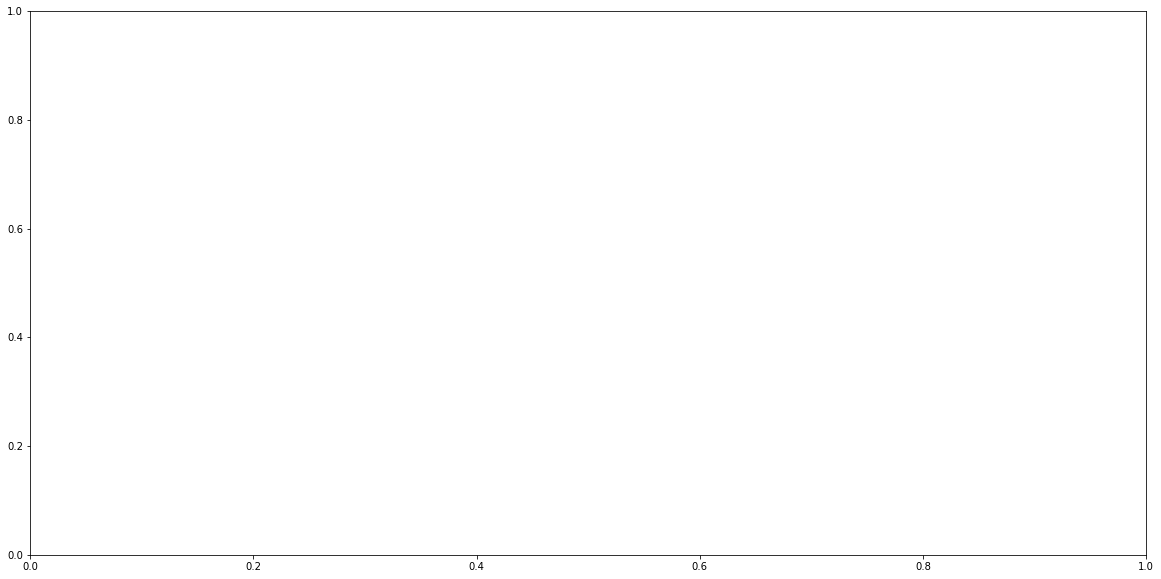

In [2]:
dataset = '8_channel_cVEP'
filename = './results/Dynamic stopping/{}.pickle'.format(dataset)
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'rb') as handle:
    results = pickle.load(handle)

In [3]:
results[1].keys()

dict_keys(['conf_max_time_steps', 'conf_diff_time_steps', 'variable_time_steps', 'ITR_time_steps', 'pred_time_step'])

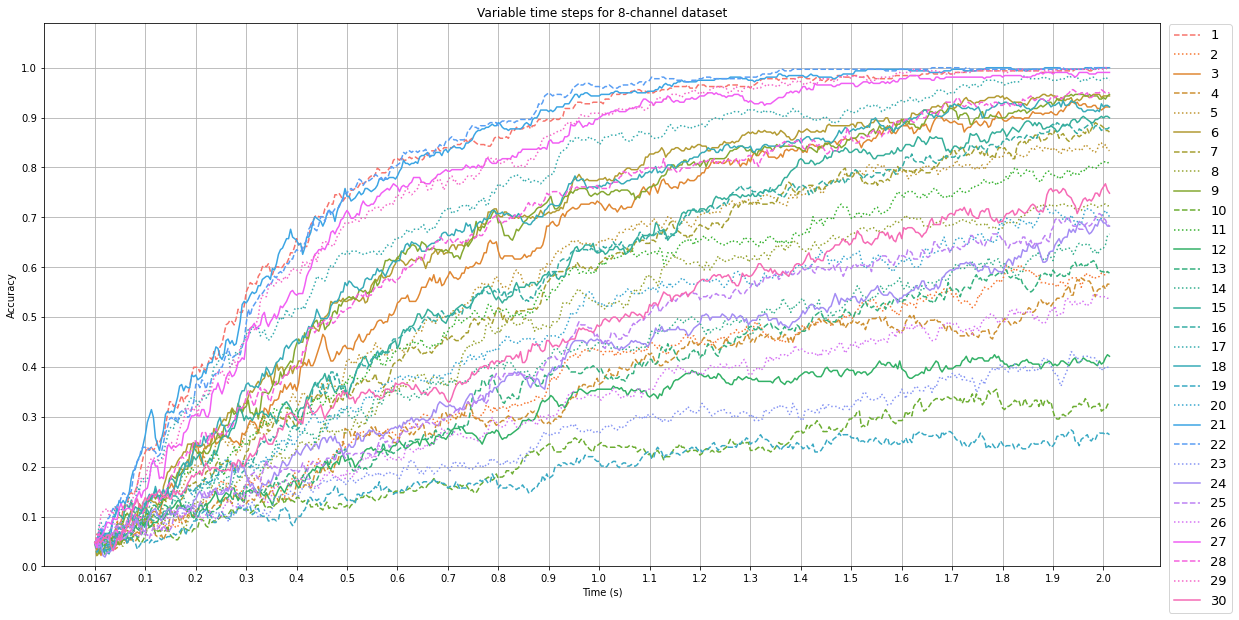

In [4]:
dataset_txt = '8-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['variable_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
ax.set_title("Variable time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()

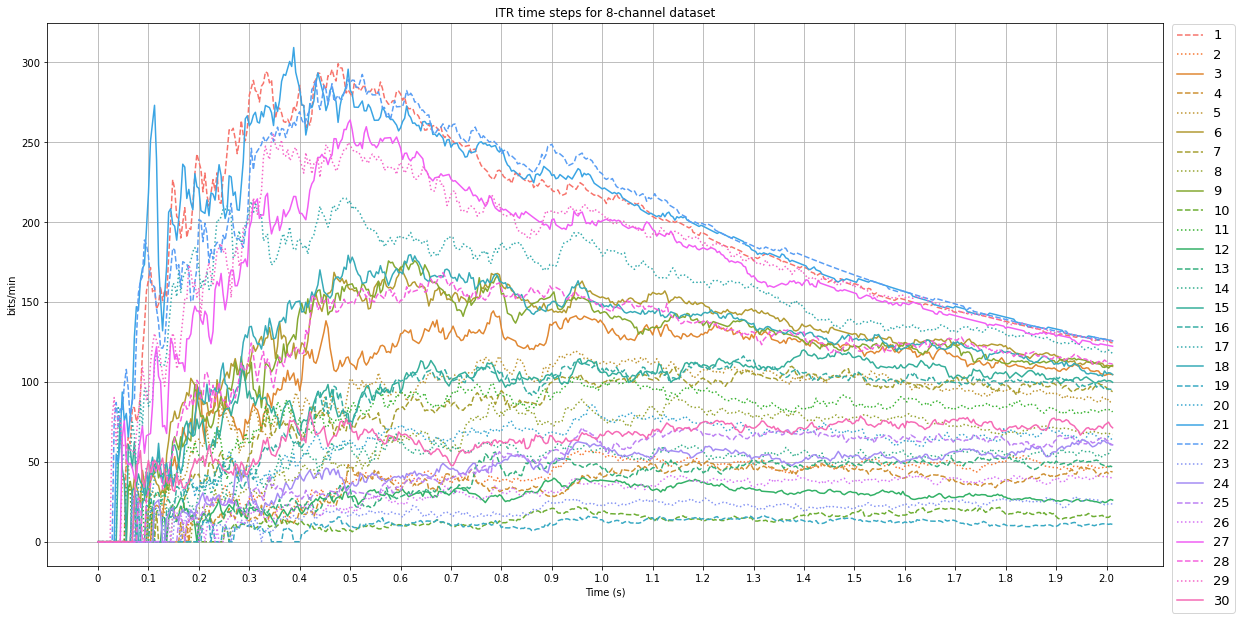

In [5]:
dataset_txt = '8-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['ITR_time_steps']
    acc_samples[:7]=0
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
#ax.set_yticks(np.arange(0,1.09,0.1))
#ax.set_ylim((0,1.09))
ax.set_xlabel('Time (s)')
ax.set_ylabel('bits/min')
ax.set_title("ITR time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()

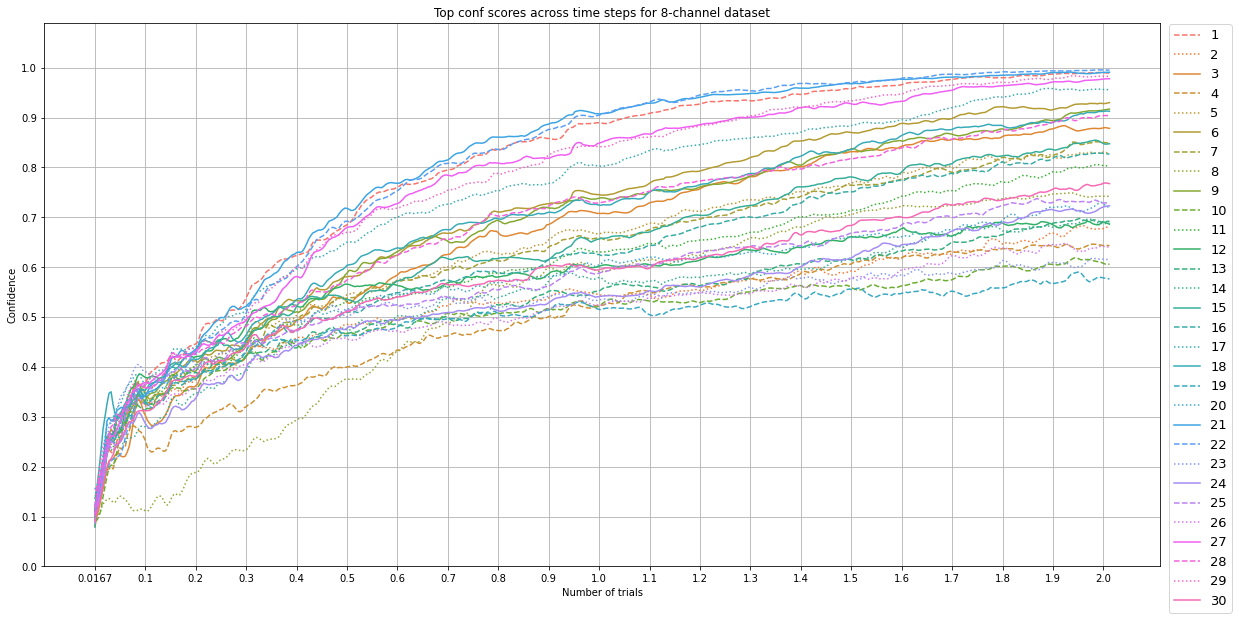

In [72]:
dataset_txt = '8-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['conf_max_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Number of trials')
ax.set_ylabel('Confidence')
ax.set_title("Top conf scores across time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()

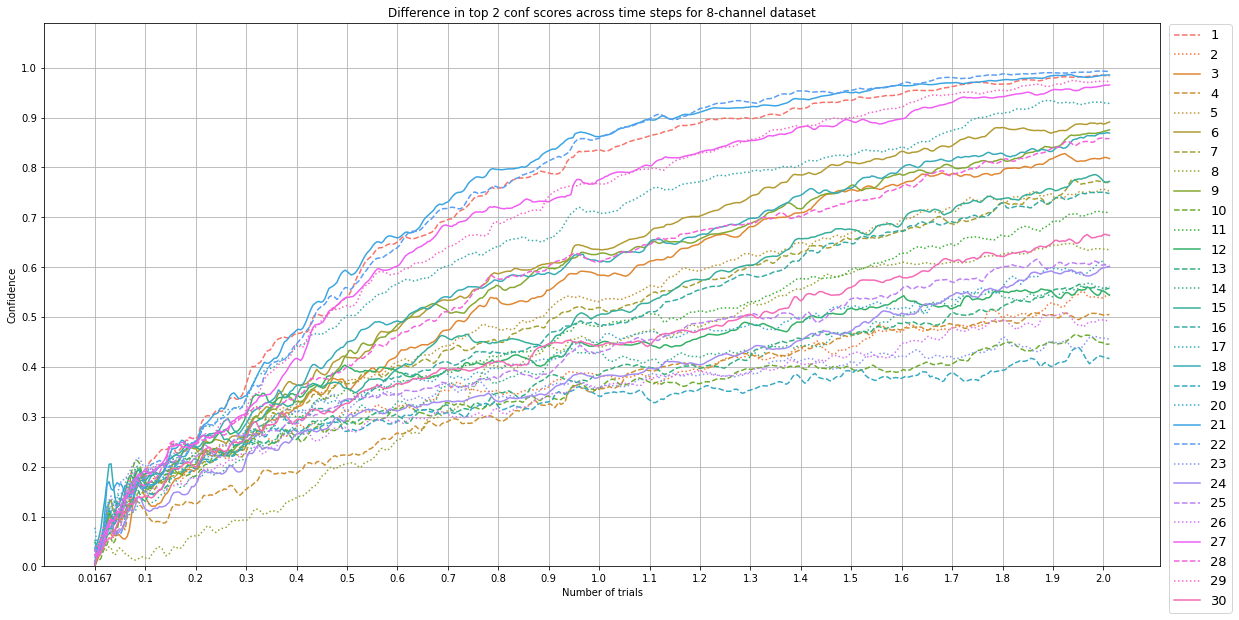

In [73]:
dataset_txt = '8-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['conf_diff_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Number of trials')
ax.set_ylabel('Confidence')
ax.set_title("Difference in top 2 conf scores across time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()

In [6]:
dataset = '256_channel_cVEP'
filename = './results/Dynamic stopping/{}.pickle'.format(dataset)
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'rb') as handle:
    results = pickle.load(handle)

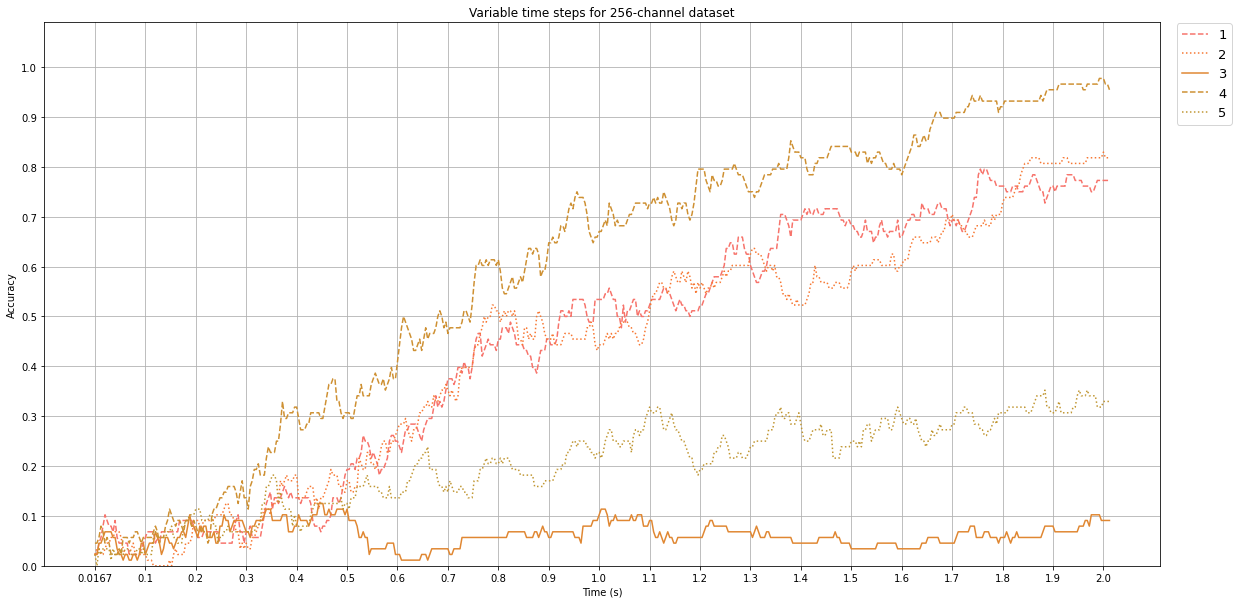

In [7]:
dataset_txt = '256-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['variable_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
ax.set_title("Variable time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()

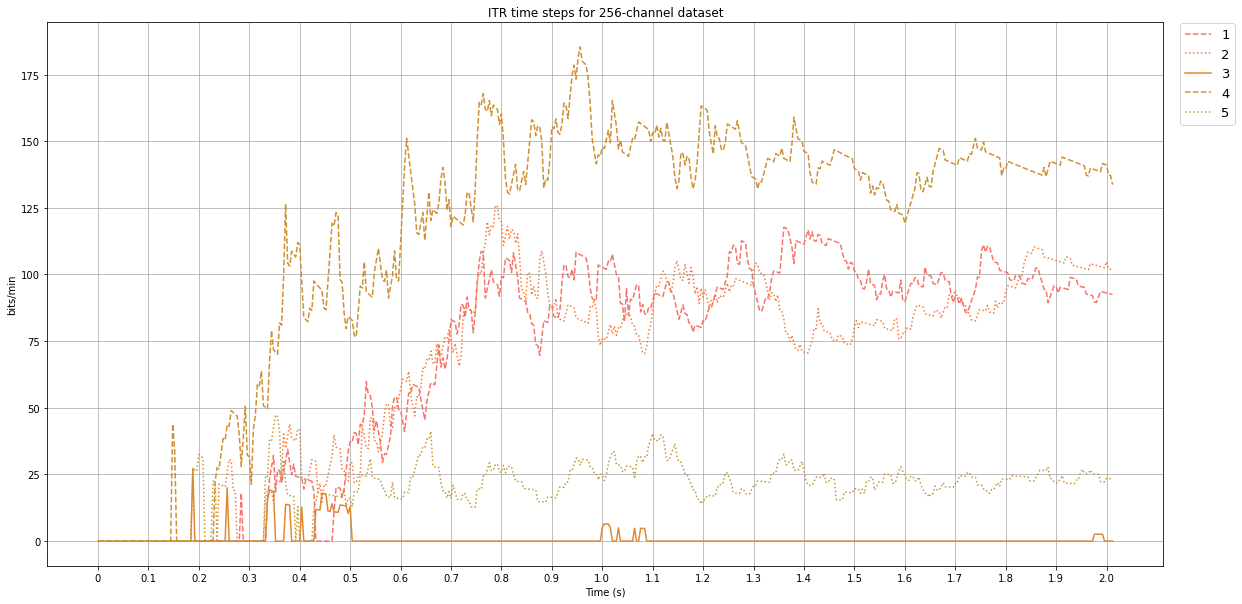

In [8]:
dataset_txt = '256-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['ITR_time_steps']
    acc_samples[:7]=0
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
#ax.set_yticks(np.arange(0,1.09,0.1))
#ax.set_ylim((0,1.09))
ax.set_xlabel('Time (s)')
ax.set_ylabel('bits/min')
ax.set_title("ITR time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()

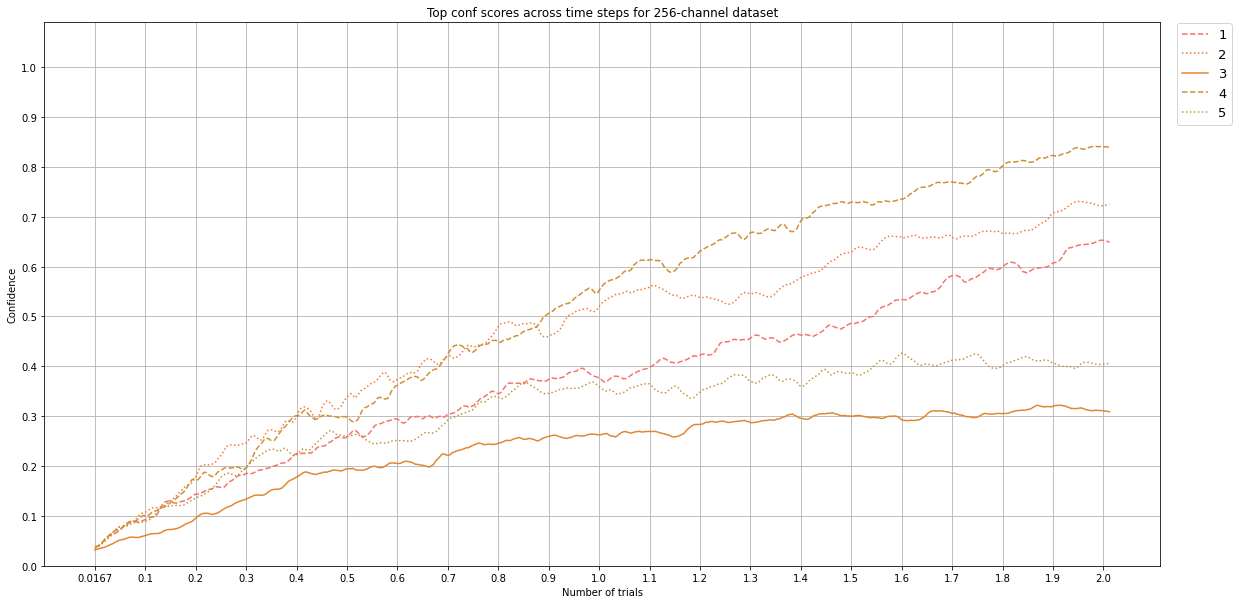

In [80]:
dataset_txt = '256-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['conf_max_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Number of trials')
ax.set_ylabel('Confidence')
ax.set_title("Top conf scores across time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()

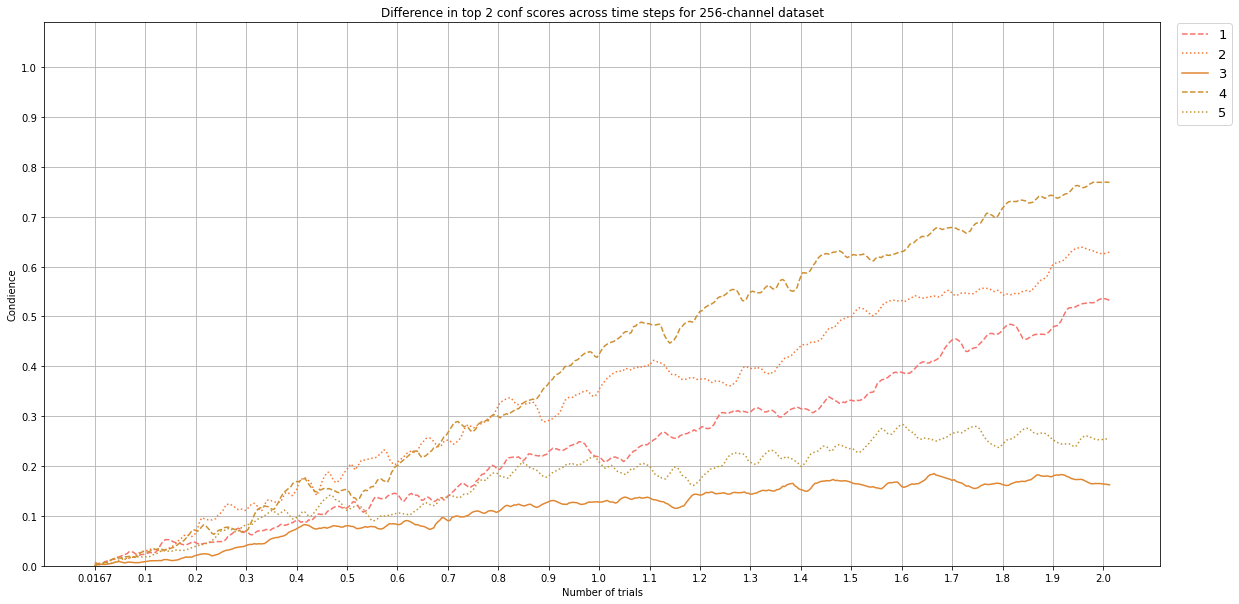

In [81]:
dataset_txt = '256-channel dataset'
bbox_l = 1.07

n_subjects = 31
NUM_COLORS = n_subjects+1
LINE_STYLES = ['solid', 'dashed', 'dotted']
NUM_STYLES = len(LINE_STYLES)

time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
time.insert(0,0.0167)

sns.reset_orig() 
clrs = sns.color_palette('husl', n_colors=NUM_COLORS) 
fig, ax = plt.subplots(figsize=(20,10))
for l in results.keys():
    
    acc_samples = results[l]['conf_diff_time_steps']
    samples = np.arange(0,len(acc_samples))
    lines = ax.plot(samples,acc_samples,label=l)
    lines[0].set_color(clrs[l])
    lines[0].set_linestyle(LINE_STYLES[l%NUM_STYLES])

ax.set_xticks(np.arange(0,504,25), time)
ax.set_yticks(np.arange(0,1.09,0.1))
ax.set_ylim((0,1.09))
ax.set_xlabel('Number of trials')
ax.set_ylabel('Condience')
ax.set_title("Difference in top 2 conf scores across time steps for {}".format(dataset_txt))

ax.legend(fontsize=13,bbox_to_anchor=(bbox_l, 1.01))
plt.grid(False)
plt.grid(True)
plt.show()
# filename = "./visualizations/Transfer learning/{}_all.png".format(dataset)
# os.makedirs(os.path.dirname(filename), exist_ok=True)   
# plt.savefig(filename) 
# plt.close()